# INFO 3402 – Class 25: Grouping and Aggregating Exercise

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sb

import numpy as np
import pandas as pd

pd.options.display.max_columns = 200

In this exercise you will build on your skills with exploring, cleaning, and combining data to analyze the factors that predict [vaccine hesitancy](https://en.wikipedia.org/wiki/Vaccine_hesitancy) in Colorado, the state with the [lowest rate of childhood vaccinations in the country](https://www.cdc.gov/mmwr/volumes/67/wr/mm6740a3.htm?s_cid=mm6740a3_w) and [strong political resistance to eliminating personal exemptions](https://coloradosun.com/2019/02/21/colorado-vaccination-rate-lowest-fix-jared-polis/) to vaccination requirements.

A reminder about the split-apply-combine paradigm of groupby-aggregation:

![split-apply-combine](https://jakevdp.github.io/PythonDataScienceHandbook/figures/03.08-split-apply-combine.png)

## Step 0: Load Data

In the appendix at the end of the document I've walked through a variety of data cleanups.

For `immunization_df` below, it contains both a "SCHOOL_CODE" and "DISTRICT_NUMBER" identifiers that *should* help with joining other datasets.

For the "SCHOOL_CODE", "DISTRICT_NUMBER", and other columns identified with the dtype option, they contain leading 0s (*e.g.*, `"0010"`) that pandas likes to cast to integers (*e.g.*, `10`). We want to keep them as strings with leading 0s.

In [2]:
immunization_df = pd.read_csv('./Schools/immunization_addresses_joined.csv',encoding='utf8',
                             dtype={'SCHOOL_CODE':str,'DISTRICT_NUMBER':str,'Zipcode':str,'PHONE':str})

# Inspect
print("There are {0:,} rows of data.".format(len(immunization_df)))
immunization_df.head()

There are 1,792 rows of data.


,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record,Street Address,Zipcode,ADDRESS,CHARTER,CITY,DISTRICT_NAME,DISTRICT_NUMBER,DISTRICT_SETTING,HIGHEST_GRADE,LOWEST_GRADE,PHONE,SCHOOL_CODE,SCHOOL_NAME,STATE,ZIPCODE
0,PUBLIC,Middle/High,PUEBLO COUNTY 70,70 ONLINE,"301 LANE 28 PUEBLO, CO 81001",165.0,168.0,0.9413,0.0209,0.0139,0.0239,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.8929,0.0000,0.0000,0.0238,0.0595,0.0,0.0238,0.0000,0.9212,0.0,0.0000,0.0303,0.0242,0.0,0.0242,0.000,301 LANE 28 PUEBLO,81001,24951 EAST HWY50,False,PUEBLO,PUEBLO COUNTY 70,2700,Urban-Suburban,12th Grade,Kindergarten,7192956518.0,5990,70 ONLINE,CO,81006
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0000,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0000,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048,2285 SOUTH FEDERAL BOULEVARD DENVER,80219,2285 SOUTH FEDERAL BOULEVARD,False,DENVER,DENVER COUNTY 1,0880,Denver Metro,12th Grade,9th Grade,7204235000.0,0010,ABRAHAM LINCOLN HIGH SCHOOL,CO,80219
2,PUBLIC,Elementary,FOUNTAIN 8,ABRAMS ELEMENTARY SCHOOL,"600 CHILES AVENUE FORT CARSON, CO 80902",0.0,477.0,0.9052,0.0130,0.0000,0.0629,0.0189,0.9329,0.0042,0.0000,0.0126,0.0000,0.0,0.0314,0.0189,0.9245,0.0021,0.0000,0.0084,0.0000,0.0,0.0461,0.0189,0.9078,0.0042,0.0000,0.0084,0.0000,0.0,0.0608,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600 CHILES AVENUE FORT CARSON,80902,600 CHILES AVENUE,False,FORT CARSON,FOUNTAIN 8,1000,Urban-Suburban,5th Grade,Kindergarten,7193821490.0,1334,ABRAMS ELEMENTARY SCHOOL,CO,80902
3,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMIA ANA MARIE SANDOVAL,"3655 WYANDOT STREET DENVER, CO 80211",0.0,295.0,0.8854,0.0393,0.0061,0.0210,0.0475,0.8576,0.0000,0.0034,0.0407,0.0034,0.0,0.0475,0.0475,0.8780,0.0000,0.0034,0.0339,0.0237,0.0,0.0102,0.0475,0.8983,0.0000,0.0034,0.0407,0.0034,0.0,0.0068,0.0475,0.9017,0.0000,0.0034,0.0305,0.0000,0.0,0.0169,0.0475,0.8915,0.0000,0.0034,0.0339,0.0000,0.0,

Load in data about free and reduced lunches. Again, we need to keep a few of the columns as string objects rather than integers, because we need their leading 0s.

In [3]:
frl_df = pd.read_excel('./Schools/free_reduced_lunches.xlsx',
                       dtype={'DISTRICT CODE':str,'SCHOOL CODE':str,'COUNTY CODE':str})

# Inspect
print("There are {0:,} rows of data.".format(len(frl_df)))
frl_df.head()

There are 1,830 rows of data.


,COUNTY CODE,COUNTY NAME,DISTRICT CODE,DISTRICT NAME,SCHOOL CODE,SCHOOL NAME,K-12 COUNT,FREE AND REDUCED COUNT,% FREE AND REDUCED,% FRL Range
0,01,ADAMS,0010,MAPLETON 1,0000,Not a school,15,NaN,NaN,0%-25%
1,01,ADAMS,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,638,404.0,0.633,50%-75%
2,01,ADAMS,0010,MAPLETON 1,0212,MAPLETON EARLY COLLEGE HIGH SCHOOL,245,148.0,0.604,50%-75%
3,01,ADAMS,0010,MAPLETON 1,0263,GLOBAL LEADERSHIP ACADEMY,199,153.0,0.769,75%-100%
4,01,ADAMS,0010,MAPLETON 1,0309,ACADEMY HIGH SCHOOL,435,237.0,0.545,50%-75%


Load in data about assessments. (This required a lot of clean-up, look in the appendix at the end of the notebook about how this was done). Again, keep the school and district codes as strings to preserve their leading 0s.

In [4]:
assessments_df = pd.read_csv('./Schools/assessments_clean.csv',encoding='utf8',
                             dtype={'District Code':str,'School Code':str})

# Inspect
print("There are {0:,} rows of data.".format(len(assessments_df)))
assessments_df.head()

There are 1,668 rows of data.


,District Name,District Code,School Name,School Code,English Participation,Math Participation,Science Participation,English Mean Score,Math Mean Score,Science Mean Score,English Score Count,Math Score Count,Science Score Count,English SD,Math SD,Science SD
0,ACADEMY 20,1040,ACADEMY CALVERT K-8 ONLINE SCHOOL,1901,0.650407,0.647541,0.565217,742.500000,730.191489,615.947368,48.0,47.0,19.0,27.694381,28.789067,61.062330
1,ACADEMY 20,1040,ACADEMY ENDEAVOUR ELEMENTARY SCHOOL,0017,0.961905,0.958599,0.962264,751.895623,752.118644,652.910891,297.0,295.0,101.0,29.010003,29.619977,72.807293
2,ACADEMY 20,1040,ACADEMY INTERNATIONAL ELEMENTARY SCHOOL,0019,0.956811,0.956811,0.927835,761.855124,759.119298,690.955556,283.0,285.0,90.0,29.878065,27.920028,77.476044
3,ACADEMY 20,1040,ACADEMY ONLINE,0110,0.787879,0.787879,NaN,743.450000,732.750000,NaN,20.0,20.0,NaN,25.008367,23.032871,NaN
4,ACADEMY 20,1040,AIR ACADEMY HIGH SCHOOL,0076,0.581325,0.614458,0.500000,754.918033,751.815385,632.875862,183.0,195.0,145.0,29.997415,22.730532,116.156676


### Step 0.1: Quick EDA

I made this plot of vaccine exemption rates by school district type and charter school status. Charter schools have significantly higher rates of vaccine exemptions than traditional schools: significantly beyond the 5% [herd immunity](https://en.wikipedia.org/wiki/Herd_immunity) threshold.

/Users/briankeegan/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


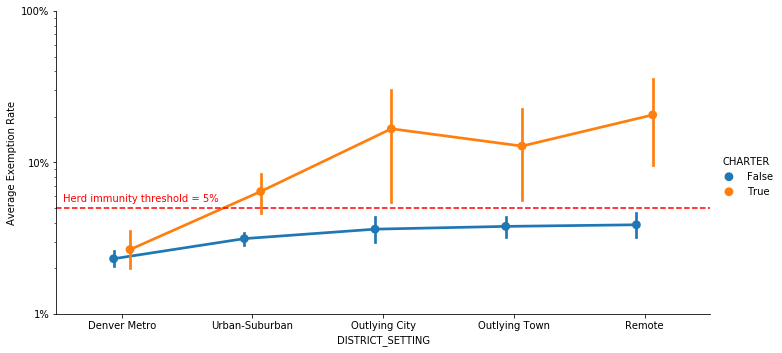

In [5]:
g = sb.catplot(x='DISTRICT_SETTING',y='Average Exemption Rate',
           hue='CHARTER',
           order=['Denver Metro','Urban-Suburban','Outlying City','Outlying Town','Remote'],
           data=immunization_df,
           kind='point',
           aspect=2,dodge=.125)

ax = g.axes[0,0]
ax.set_ylim((1e-2,1e0))
ax.set_yscale('log')

# Annotate
ax.axhline(.05,c='r',ls='--')
ax.annotate('Herd immunity threshold = 5%',(-.45,.055),color='r')

# From: https://stackoverflow.com/a/46574866/1574687
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))

We can also explore the relationship between school size and exemption rates.

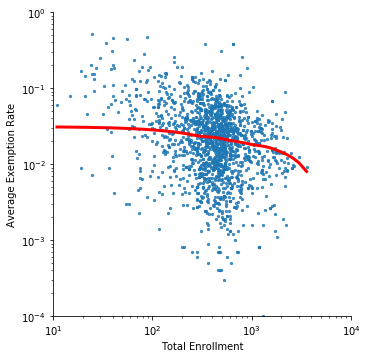

In [6]:
# https://stackoverflow.com/a/35827498/1574687

g = sb.lmplot(x='Total Enrollment',
              y='Average Exemption Rate',
              data=immunization_df,
              lowess=True,
              scatter_kws={'s':5},
              line_kws={'color': 'red','linewidth':3})

ax = g.axes[0,0]
ax.set_xlim((1e1,1e4))
ax.set_ylim((1e-4,1e0))
ax.set_xscale('log')
ax.set_yscale('log')

## Step 1: Cleaning data
Load in school-level demographic data about student ethnicity and gender. Note there are almost 7 times more rows that the other datasets we've loaded. Why is that?

In [7]:
# Read in data
demographics_df = pd.read_excel('./Schools/ethnicity_gender.xlsx',
                                header=0,skiprows=[1],
                                dtype={'Org. Code':str,'School Code':str})

# Make new columns that add up row values for boys and girls
male_cols = [col for col in demographics_df.columns if 'Male' in col]
female_cols = [col for col in demographics_df.columns if 'Female' in col]
demographics_df['Male Total'] = demographics_df[male_cols].sum(axis=1)
demographics_df['Female Total'] = demographics_df[female_cols].sum(axis=1)
demographics_df['Native American Total'] = demographics_df[demographics_df.columns[5:7]].sum(axis=1)
demographics_df['Asian Total'] = demographics_df[demographics_df.columns[7:9]].sum(axis=1) + demographics_df[demographics_df.columns[15:17]].sum(axis=1)
demographics_df['Black Total'] = demographics_df[demographics_df.columns[9:11]].sum(axis=1)
demographics_df['Hispanic Total'] = demographics_df[demographics_df.columns[11:13]].sum(axis=1)
demographics_df['White Total'] = demographics_df[demographics_df.columns[13:15]].sum(axis=1)
demographics_df['Multiracial Total'] = demographics_df[demographics_df.columns[17:19]].sum(axis=1)
demographics_df['Non-white Total'] = demographics_df['PK-12 Total'] - demographics_df['White Total']

# Inspect
print("There are {0:,} rows of data.".format(len(demographics_df)))
demographics_df.head()

There are 13,394 rows of data.


,Org. Code,Organization Name,School Code,School Name,Grade Level,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,Male Total,Female Total,Native American Total,Asian Total,Black Total,Hispanic Total,White Total,Multiracial Total,Non-white Total
0,0010,MAPLETON 1,0000,Not a school,120 (12th),0,0,0,0,0,0,2,8,3,2,0,0,0,0,15,10,5,0,0,0,10,5,0,10
1,0010,MAPLETON 1,0000,Not a school,ALL GRADES TOTAL,0,0,0,0,0,0,2,8,3,2,0,0,0,0,15,10,5,0,0,0,10,5,0,10
2,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,070 (7th),2,0,1,0,1,0,37,41,11,17,0,0,2,0,112,58,54,2,1,1,78,28,2,84
3,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,080 (8th),1,0,1,1,2,0,49,39,19,9,0,0,2,1,124,49,74,1,2,2,88,28,3,96
4,0010,MAPLETON 1,0187,MAPLETON EXPEDITIONARY SCHOOL OF THE ARTS,090 (9th),0,0,1,0,1,0,41,53,20,14,0,0,1,2,133,69,64,0,1,1,94,34,3,99


Perform a groupby-aggregation operation on `demographics_df` to get the total number of students of the gender, race, and ethnicity columns for each school. Save the result as `demographics_gb`. I've made the aggregation dictionary for you.

You'll also need to reset the index to return the groupby keys to columns in the DataFrame. You may also want to perform some querying or boolean indexing to remove extraneous "School Code"s like "0000".

In [8]:
agg_d = {col:'sum' for col in demographics_df.columns[5:]}

# Just to see what the agg_d looks like
agg_d

{'American Indian or Alaskan Native Female': 'sum',
 'American Indian or Alaskan Native Male': 'sum',
 'Asian Female': 'sum',
 'Asian male': 'sum',
 'Black or African American Female': 'sum',
 'Black or African American Male': 'sum',
 'Hispanic or Latino Female': 'sum',
 'Hispanic or Latino Male': 'sum',
 'White Female': 'sum',
 'White Male': 'sum',
 'Native Hawaiian or Other Pacific Islander Female': 'sum',
 'Native Hawaiian or Other Pacific Islander Male': 'sum',
 'Two or More Races Female': 'sum',
 'Two or More Races Male': 'sum',
 'PK-12 Total': 'sum',
 'Male Total': 'sum',
 'Female Total': 'sum',
 'Native American Total': 'sum',
 'Asian Total': 'sum',
 'Black Total': 'sum',
 'Hispanic Total': 'sum',
 'White Total': 'sum',
 'Multiracial Total': 'sum',
 'Non-white Total': 'sum'}

Write the groupby-aggregation here.

In [9]:
demographics_gb = demographics_df.groupby(['School Code','Org. Code','School Name']).agg(agg_d).reset_index()

demographics_gb['Non-white Pct'] = demographics_gb['Non-white Total']/demographics_gb['PK-12 Total']
demographics_gb['White Pct'] = demographics_gb['White Total']/demographics_gb['PK-12 Total']

print("There are {0:,} rows of data.".format(len(demographics_gb)))


There are 1,885 rows of data.


## Step 2: Join in other data sets

Using `immunization_df` as the left DataFrame, `join` or `merge` in the `frl_df`, `assessments_df`, and `demographics_gb` DataFrames using left joins to create a `joined_df`.

What columns will you join on? 

(Hint 1: I *really* made sure the numeric codes for schools and districts were consistently formatted as strings when we read them in from file.)

(Hint 2: I almost always look at the `.head()` of DataFrames I'm joining to make sure I have the column names right.)

In [10]:
joined_df = pd.merge(left=immunization_df,right=frl_df,
                     left_on=['SCHOOL_CODE','DISTRICT_NUMBER'],
                     right_on=['SCHOOL CODE','DISTRICT CODE'],
                     how='left')

joined_df = pd.merge(left=joined_df,right=demographics_gb,
                     left_on=['SCHOOL_CODE','DISTRICT_NUMBER'],
                     right_on=['School Code','Org. Code'],
                     how='left')

joined_df = pd.merge(left=joined_df,right=assessments_df,
                     left_on=['SCHOOL_CODE','DISTRICT_NUMBER'],
                     right_on=['School Code','District Code'],
                     how='left')

print("There are {0:,} rows of data.".format(len(joined_df)))
joined_df.head()

There are 1,792 rows of data.


,Facility Type,School Type,School District,School Name_x,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record,Street Address,Zipcode,ADDRESS,CHARTER,CITY,DISTRICT_NAME,DISTRICT_NUMBER,DISTRICT_SETTING,HIGHEST_GRADE,LOWEST_GRADE,PHONE,SCHOOL_CODE,SCHOOL_NAME,STATE,ZIPCODE,COUNTY CODE,COUNTY NAME,DISTRICT CODE,DISTRICT NAME,SCHOOL CODE,SCHOOL NAME,K-12 COUNT,FREE AND REDUCED COUNT,% FREE AND REDUCED,% FRL Range,School Code_x,Org. Code,School Name_y,American Indian or Alaskan Native Female,American Indian or Alaskan Native Male,Asian Female,Asian male,Black or African American Female,Black or African American Male,Hispanic or Latino Female,Hispanic or Latino Male,White Female,White Male,Native Hawaiian or Other Pacific Islander Female,Native Hawaiian or Other Pacific Islander Male,Two or More Races Female,Two or More Races Male,PK-12 Total,Male Total,Female Total,Native American Total,Asian Total,Black Total,Hispanic Total,White Total,Multiracial Total,Non-white Total,Non-white Pct,White Pct,District Name,District Code,School Name,School Code_y,English Participation,Math Participation,Science Participation,English Mean Score,Math Mean Score,Science Mean Score,English Score Count,Math Score Count,Science Score Count,English SD,Math SD,Science SD
0,PUBLIC,Middle/High,PUEBLO COUNTY 70,70 ONLINE,"301 LANE 28 PUEBLO, CO 81001",165.0,168.0,0.9413,0.0209,0.0139,0.0239,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.8929,0.0000,0.0000,0.0238,0.0595,0.0,0.0238,0.0000,0.9212,0.0,0.0000,0.0303,0.0242,0.0,0.0242,0.000,301 LANE 28 PUEBLO,81001,24951 EAST HWY50,False,PUEBLO,PUEBLO COUNTY 70,2700,Urban-Suburban,12th Grade,Kindergarten,7192956518.0,5990,70 ONLINE,CO,81006,51,PUEBLO,2700,PUEBLO COUNTY 70,5990,70 ONLINE,159.0,108.0,0.679,50%-75%,5990,2700,70 ONLINE,4.0,0.0,0.0,0.0,2.0,2.0,44.0,84.0,72.0,94.0,0.0,0.0,6.0,10.0,318.0,190.0,128.0,4.0,0.0,4.0,128.0,166.0,16.0,152.0,0.477987,0.522013,PUEBLO COUNTY 70,2700,70 ONLINE,5990,0.762500,0.848101,0.921875,729.900000,716.045455,550.282051,20.0,22.0,39.0,27.712623,20.408862,89.054965
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0000,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0000,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,

### Step 2.1: Quick EDA

Make a `lmplot` of the relationship between some of the school-level variables (free/reduced lunches, demographics, assessments, *etc*.) you joined in and exemption rates.

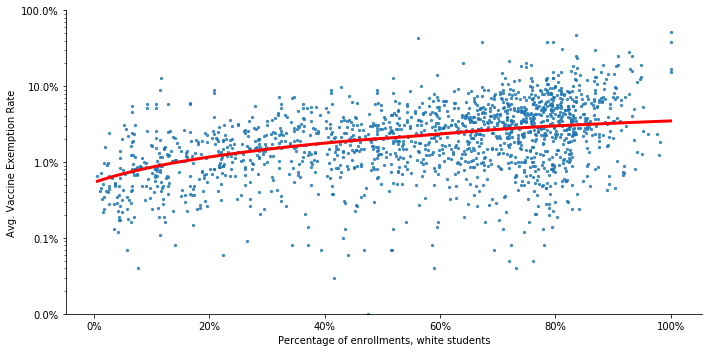

In [11]:
g = sb.lmplot(x='White Pct',
              y='Average Exemption Rate',
              data=joined_df,
              lowess=True,
              scatter_kws={'s':5},
              line_kws={'color': 'red','linewidth':3},aspect=2)

ax = g.axes[0,0]
# ax.set_xlim((1e-2,1e0))
ax.set_ylim((1e-4,1e0))
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Percentage of enrollments, white students')
ax.set_ylabel('Avg. Vaccine Exemption Rate')
# ax.set_title('Vaccine exemptions rise with white student enrollments')
# ax.axhline(.05,c='r',ls='--')
# ax.annotate('Herd immunity threshold',(-.45,.0525),color='r')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}'))
plt.tight_layout()
plt.savefig('enrollments_white.png',dpi=300,bbox_to_anchor='tight')

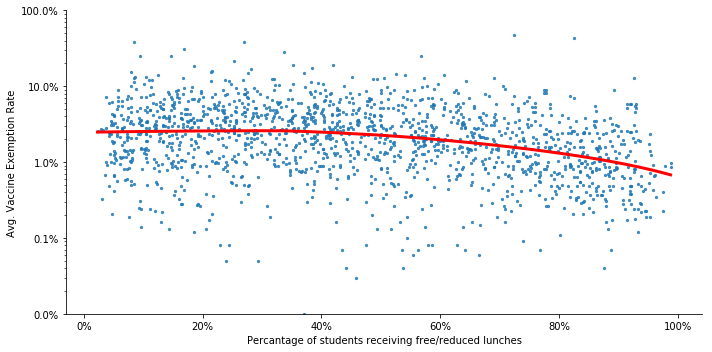

In [12]:
g = sb.lmplot(x='% FREE AND REDUCED',
              y='Average Exemption Rate',
              data=joined_df,
              lowess=True,
              scatter_kws={'s':5},
              line_kws={'color': 'red','linewidth':3},aspect=2)

ax = g.axes[0,0]
# ax.set_xlim((1e1,1e4))
ax.set_ylim((1e-4,1e0))
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Percantage of students receiving free/reduced lunches')
ax.set_ylabel('Avg. Vaccine Exemption Rate')
# ax.set_title('Vaccine exemptions rise with white student enrollments')
# ax.axhline(.05,c='r',ls='--')
# ax.annotate('Herd immunity threshold',(-.45,.0525),color='r')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}'))
plt.tight_layout()
plt.savefig('frl.png',dpi=300,bbox_to_anchor='tight')

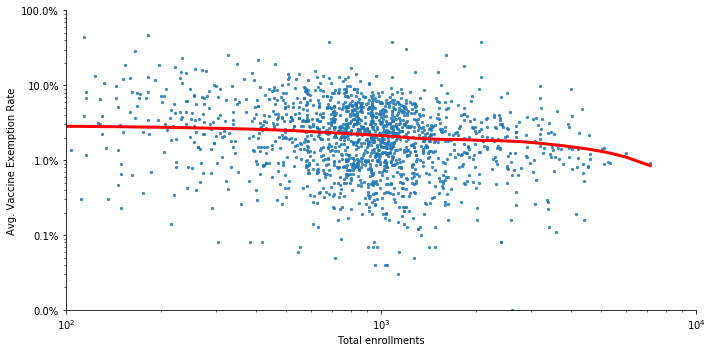

In [13]:
g = sb.lmplot(x='PK-12 Total',
              y='Average Exemption Rate',
              data=joined_df,
              lowess=True,
              scatter_kws={'s':5},
              line_kws={'color': 'red','linewidth':3},aspect=2)

ax = g.axes[0,0]
ax.set_xlim((1e2,1e4))
ax.set_ylim((1e-4,1e0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Total enrollments')
ax.set_ylabel('Avg. Vaccine Exemption Rate')
# ax.set_title('Vaccine exemptions rise with white student enrollments')
# ax.axhline(.05,c='r',ls='--')
# ax.annotate('Herd immunity threshold',(-.45,.0525),color='r')
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}'))
plt.tight_layout()
plt.savefig('enrollments_total.png',dpi=300,bbox_to_anchor='tight')

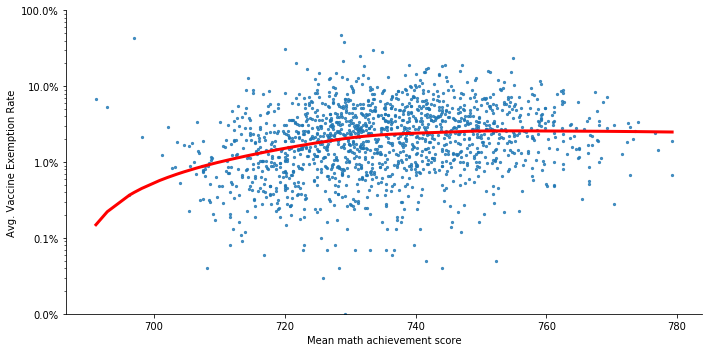

In [14]:
g = sb.lmplot(x='Math Mean Score',
              y='Average Exemption Rate',
              data=joined_df,
              lowess=True,
              scatter_kws={'s':5},
              line_kws={'color': 'red','linewidth':3},aspect=2)

ax = g.axes[0,0]
# ax.set_xlim((1e2,1e4))
ax.set_ylim((1e-4,1e0))
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean math achievement score')
ax.set_ylabel('Avg. Vaccine Exemption Rate')
# ax.set_title('Vaccine exemptions rise with white student enrollments')
# ax.axhline(.05,c='r',ls='--')
# ax.annotate('Herd immunity threshold',(-.45,.0525),color='r')
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}'))
plt.tight_layout()
plt.savefig('math_mean_score.png',dpi=300,bbox_to_anchor='tight')

In [15]:
_df = joined_df[['Math Mean Score','Average Exemption Rate']].dropna(how='any')
np.corrcoef(_df['Math Mean Score'],_df['Average Exemption Rate'])

array([[1.        , 0.12296378],
       [0.12296378, 1.        ]])

Make a `catplot` of exemption rates on the *y*-axis and some categorical variable on the *x*-axis. Add a hue variable if you're feeling ambitious.

For example, you could plot "DISTRICT_SETTING" on the *x*-axis and "% FRL Range" as a hue.

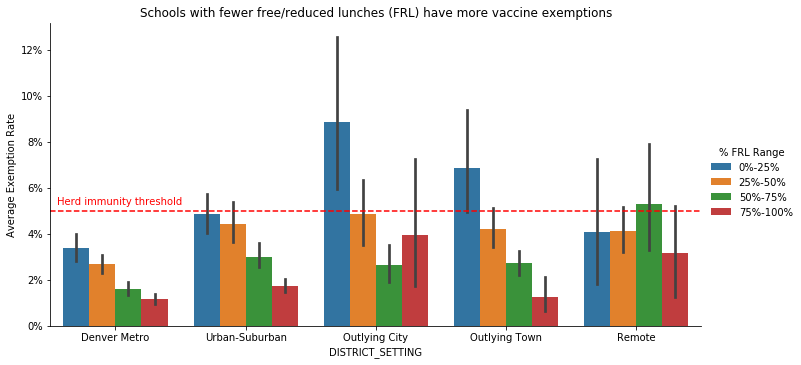

In [16]:
g = sb.catplot(x='DISTRICT_SETTING',y='Average Exemption Rate',
               hue='% FRL Range',
               order=['Denver Metro','Urban-Suburban','Outlying City','Outlying Town','Remote'],
               hue_order=['0%-25%', '25%-50%', '50%-75%', '75%-100%'],
               data=joined_df,
               kind='bar',
               aspect=2,dodge=.125)

ax = g.axes[0,0]
# ax.set_ylim((0,.12))
# ax.set_yscale('log')

# Annotate
ax.axhline(.05,c='r',ls='--')
ax.annotate('Herd immunity threshold',(-.45,.0525),color='r')
ax.set_title('Schools with fewer free/reduced lunches (FRL) have more vaccine exemptions')

# From: https://stackoverflow.com/a/46574866/1574687
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))

# plt.tight_layout()
plt.savefig('free_lunches_district.png',dpi=300,bbox_to_anchor='tight')

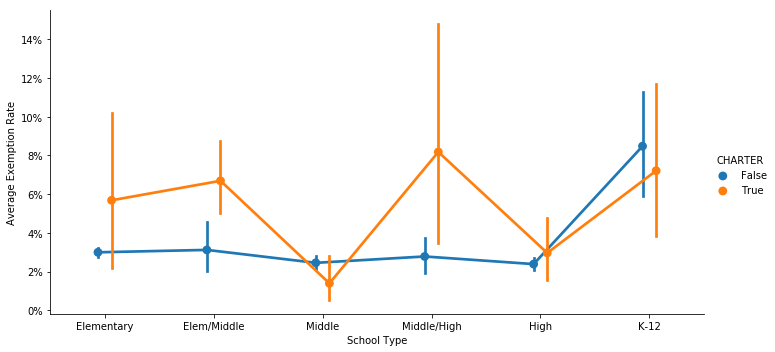

In [17]:
g = sb.catplot(x='School Type',y='Average Exemption Rate',
               hue='CHARTER',
               order=['Elementary','Elem/Middle','Middle','Middle/High','High','K-12'],
               data=joined_df[joined_df['School Type'] != 'PRIVATE'],
               kind='point',
               aspect=2,dodge=.125)

ax = g.axes[0,0]
# ax.set_ylim((0,.12))
# ax.set_yscale('log')

# Annotate
# ax.set_title('Schools with fewer free/reduced lunches (FRL) have more vaccine exemptions')

# From: https://stackoverflow.com/a/46574866/1574687
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))

# plt.tight_layout()
plt.savefig('school_type_charter.png',dpi=300,bbox_to_anchor='tight')

If you want to see what some of the cities in each of the "DISTRICT_SETTING"s are, this code will summarize.

In [252]:
joined_df.loc[joined_df['DISTRICT_SETTING'] == 'Urban-Suburban','CITY'].unique()

array(['PUEBLO', 'FORT CARSON', 'COLORADO SPRINGS', 'WESTMINSTER',
       'USAF ACADEMY', 'DURANGO', 'GRAND JUNCTION', 'FOUNTAIN',
       'AVONDALE', 'LOVELAND', 'FORT COLLINS', 'MONUMENT', 'GREELEY',
       'BERTHOUD', 'TIMNATH', 'BEULAH', 'LAPORTE', 'PUEBLO WEST', 'EVANS',
       'CLIFTON', 'COMMERCE CITY', 'FT COLLINS', 'COLORADO CITY',
       'ARVADA', 'WELLINGTON', 'PEYTON', 'CALHAN', 'FRUITA', 'GATEWAY',
       'GOLDEN', 'AURORA', 'GRANBY', 'LIVERMORE', 'LOMA',
       'MANITOU SPRINGS', 'FALCON', 'STEAMBOAT SPRINGS', 'DENVER',
       'PALISADE', 'PALMER LAKE', 'RED FEATHER LAKES', 'CARBONDALE',
       'RYE', 'SALIDA', 'GYPSUM', 'BELLVUE', 'GLENWOOD SPRINGS',
       'CHIPITA PARK'], dtype=object)

Perform dimensionality reduction on the data.

In [30]:
cols = ['Facility Type','School Type','Total Enrollment',
        'HepB: Personal Exemptions Rate','Dtap: Personal Exemptions Rate','Polio: Personal Exemptions Rate','MMR: Personal Exemptions Rate','Varicella: Personal Exemptions Rate','Tdap: Personal Exemptions',
        'CHARTER','DISTRICT_SETTING','% FREE AND REDUCED',
        'American Indian or Alaskan Native Female','American Indian or Alaskan Native Male','Asian Female','Asian male','Black or African American Female','Black or African American Male','Hispanic or Latino Female','Hispanic or Latino Male','White Female','White Male','Native Hawaiian or Other Pacific Islander Female','Native Hawaiian or Other Pacific Islander Male','Two or More Races Female','Two or More Races Male',
        'English Mean Score','Math Mean Score','Science Mean Score']

subset_df = joined_df[cols].fillna(0)
subset_df = subset_df[subset_df['DISTRICT_SETTING'] != 'Colorado BOCES']
subset_df.replace({'Facility Type':{'PUBLIC':True,'PRIVATE':False}},inplace=True)
subset_df.rename({'Facility Type':'Public Facility'})
dummified_df = pd.get_dummies(subset_df,columns=['School Type','DISTRICT_SETTING'])


In [34]:
from umap import UMAP
from sklearn.cluster import DBSCAN, KMeans

u = UMAP(n_components=2, n_neighbors=5, random_state=42)
X_umap = u.fit_transform(dummified_df.values)

/Users/briankeegan/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [51]:
dbscan = DBSCAN(eps=.5,min_samples=10,n_jobs=-1)
dbscan_clusters = dbscan.fit_predict(X_umap)

In [53]:
dummified_df['umap_X'] = X_umap[:,0]
dummified_df['umap_Y'] = X_umap[:,1]
dummified_df['umap_cluster'] = dbscan_clusters

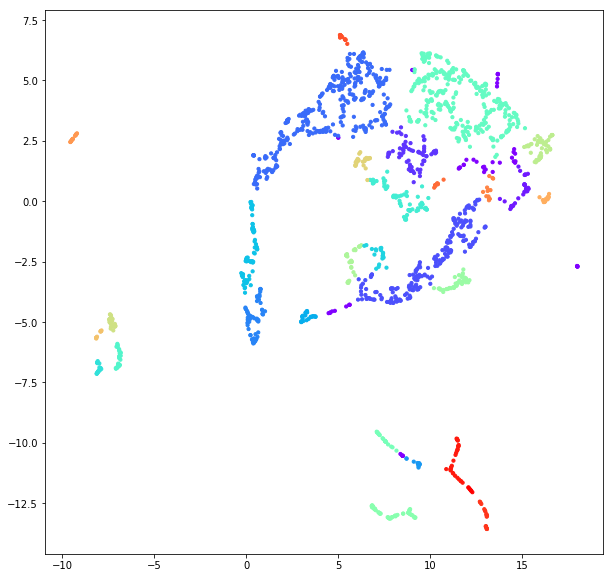

In [59]:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(X_umap[:,0],X_umap[:,1],s=10,c=dbscan_clusters,cmap='rainbow')

## Step 3: Aggregate to district-level statistics

Take the `joined_df` and create a `joined_gb` by grouping on district names or codes.

Write an aggregation dictionary to aggregate the average statistics for some of the plots you made above. Use `.agg` with the aggregation dictionary to create a `joined_agg` DataFrame.

Re-do the plots you made above using the `joined_agg` DataFrame.

Are the findings using the district-level data similar to the findings using the school-level data?

## Bonus step: Run a regression

Most of the exploratory analyses above were bivariate. We will talk after spring break about regressions and hypothesis testing. This is mostly for my own curiosity.

`statsmodels` doesn't like spaces in the variables names, so clean that up.

In [18]:
clean_cols = ['_'.join(col.split(' ')) for col in joined_df.columns]
joined_clean_cols_df = joined_df.copy()
joined_clean_cols_df.columns = clean_cols
joined_clean_cols_df.rename(columns={"%_FREE_AND_REDUCED":"PCT_FREE_AND_REDUCED"},inplace=True)

# Also remove an errant DISTRICT_SETTING
joined_clean_cols_df = joined_clean_cols_df[joined_clean_cols_df['DISTRICT_SETTING'] != 'Colorado BOCES']

In [19]:
joined_clean_cols_df.head()

,Facility_Type,School_Type,School_District,School_Name_x,Address,6-12_Grade_Enrollment,Total_Enrollment,Average_Up_to_Date_Rate,Average_Exemption_Rate,Average_In_Process_Rate,Average_Incomplete_Record_Rate,Average_No_Record_Rate,HepB:_Up_to_Date_Rate,HepB:_Medical_Exemptions_Rate,HepB:_Religious_Exemptions_Rate,HepB:_Personal_Exemptions_Rate,HepB:_In_Process_Rate,HepB:_McKinny-Vento_Exemptions_Rate,HepB:_Incomplete_Record_Rate,HepB:_No_Record_Rate,Dtap:_Up_to_Date_Rate,Dtap:_Medical_Exemptions_Rate,Dtap:_Religious_Exemptions_Rate,Dtap:_Personal_Exemptions_Rate,Dtap:_In_Process_Rate,Dtap:_McKinny-Vento_Exemptions_Rate,Dtap:_Incomplete_Record_Rate,Dtap:_No_Record_Rate,Polio:_Up_to_Date_Rate,Polio:_Medical_Exemptions_Rate,Polio:_Religious_Exemptions_Rate,Polio:_Personal_Exemptions_Rate,Polio:_In_Process_Rate,Polio:_McKinny-Vento_Exemptions_Rate,Polio:_Incomplete_Record_Rate,Polio:_No_Record_Rate,MMR:_Up_to_Date_Rate,MMR:_Medical_Exemptions_Rate,MMR:_Religious_Exemptions_Rate,MMR:_Personal_Exemptions_Rate,MMR:_In_Process_Rate,MMR:_McKinny-Vento_Exemptions_Rate,MMR:_Incomplete_Record_Rate,MMR:_No_Record_Rate,Varicella:_Up_to_Date_Rate,Varicella:_Medical_Exemptions_Rate,Varicella:_Religious_Exemptions_Rate,Varicella:_Personal_Exemptions_Rate,Varicella:_In_Process_Rate,Varicella:_McKinny-Vento_Exemptions_Rate,Varicella:_Incomplete_Record_Rate,Varicella:_No_Record_Rate,Tdap:_Up_to_Date,Tdap:_Medical_Exemptions,Tdap:_Religious_Exemptions,Tdap:_Personal_Exemptions,Tdap:_In_Process,Tdap:_McKinny-Vento_Exemptions,Tdap:_Incomplete_Record,Tdap:_No_Record,Street_Address,Zipcode,ADDRESS,CHARTER,CITY,DISTRICT_NAME,DISTRICT_NUMBER,DISTRICT_SETTING,HIGHEST_GRADE,LOWEST_GRADE,PHONE,SCHOOL_CODE,SCHOOL_NAME,STATE,ZIPCODE,COUNTY_CODE,COUNTY_NAME,DISTRICT_CODE,DISTRICT_NAME,SCHOOL_CODE,SCHOOL_NAME,K-12_COUNT,FREE_AND_REDUCED_COUNT,PCT_FREE_AND_REDUCED,%_FRL_Range,School_Code_x,Org._Code,School_Name_y,American_Indian_or_Alaskan_Native_Female,American_Indian_or_Alaskan_Native_Male,Asian_Female,Asian_male,Black_or_African_American_Female,Black_or_African_American_Male,Hispanic_or_Latino_Female,Hispanic_or_Latino_Male,White_Female,White_Male,Native_Hawaiian_or_Other_Pacific_Islander_Female,Native_Hawaiian_or_Other_Pacific_Islander_Male,Two_or_More_Races_Female,Two_or_More_Races_Male,PK-12_Total,Male_Total,Female_Total,Native_American_Total,Asian_Total,Black_Total,Hispanic_Total,White_Total,Multiracial_Total,Non-white_Total,Non-white_Pct,White_Pct,District_Name,District_Code,School_Name,School_Code_y,English_Participation,Math_Participation,Science_Participation,English_Mean_Score,Math_Mean_Score,Science_Mean_Score,English_Score_Count,Math_Score_Count,Science_Score_Count,English_SD,Math_SD,Science_SD
0,PUBLIC,Middle/High,PUEBLO COUNTY 70,70 ONLINE,"301 LANE 28 PUEBLO, CO 81001",165.0,168.0,0.9413,0.0209,0.0139,0.0239,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.8929,0.0000,0.0000,0.0238,0.0595,0.0,0.0238,0.0000,0.9212,0.0,0.0000,0.0303,0.0242,0.0,0.0242,0.000,301 LANE 28 PUEBLO,81001,24951 EAST HWY50,False,PUEBLO,PUEBLO COUNTY 70,2700,Urban-Suburban,12th Grade,Kindergarten,7192956518.0,5990,70 ONLINE,CO,81006,51,PUEBLO,2700,PUEBLO COUNTY 70,5990,70 ONLINE,159.0,108.0,0.679,50%-75%,5990,2700,70 ONLINE,4.0,0.0,0.0,0.0,2.0,2.0,44.0,84.0,72.0,94.0,0.0,0.0,6.0,10.0,318.0,190.0,128.0,4.0,0.0,4.0,128.0,166.0,16.0,152.0,0.477987,0.522013,PUEBLO COUNTY 70,2700,70 ONLINE,5990,0.762500,0.848101,0.921875,729.900000,716.045455,550.282051,20.0,22.0,39.0,27.712623,20.408862,89.054965
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0000,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0000,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.938

Run the regression.

In [20]:
import statsmodels.formula.api as smf

model = smf.ols(formula = "Average_Exemption_Rate ~ C(School_Type) + Total_Enrollment + C(CHARTER) + C(DISTRICT_SETTING) + White_Pct + PCT_FREE_AND_REDUCED + English_Mean_Score + Math_Mean_Score + Science_Mean_Score", data=joined_clean_cols_df).fit()

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Average_Exemption_Rate   R-squared:                       0.234
Model:                                OLS   Adj. R-squared:                  0.225
Method:                     Least Squares   F-statistic:                     26.52
Date:                    Fri, 15 Mar 2019   Prob (F-statistic):           1.60e-73
Time:                            13:05:36   Log-Likelihood:                 3346.1
No. Observations:                    1498   AIC:                            -6656.
Df Residuals:                        1480   BIC:                            -6561.
Df Model:                              17                                         
Covariance Type:                nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

## Appendix

Cleaning up the datasets.

### Assessments
The assessment data requires a fair amount of cleanup:
* The school names skip rows, which needs to be corrected
* The district and school codes need to be extracted from the "State/District/School" column
* The English and Math scores need to be combined with the Science scores
* The assessment data is "long" and needs to be pivoted to "wide"
* After pivoting, the columns need to be simplified and renamed

In [151]:
# Read in data, NAs are -, drop rows with all NAs
cmas_lam_df = pd.read_excel('./Schools/assessments_arts_math.xlsx',
                            na_values='-',
                            dtype={'District Code':str,'School Code':str}).dropna(how='all')

# Remove column with test name
cmas_lam_df.drop(columns=['Test Name'],inplace=True)

# Clean up skipped labels
sds_lam_labels = []
for sds in cmas_lam_df['State/District/School'].dropna().unique():
    sds_lam_labels.append(sds)
    sds_lam_labels.append(sds)
cmas_lam_df['State/District/School'] = sds_lam_labels

# Get the District and School codes from the State/District/School column
re_pattern = r'([^(]+)\((\d+)\):([^(]+)\((\d+)\)'
assessment_re_cols = ['District Name','District Code','School Name','School Code']
column_relabel = {i:n for i,n in enumerate(assessment_re_cols)}

lam_re_match_df = cmas_lam_df['State/District/School'].str.extract(re_pattern)
lam_re_match_df.rename(columns=column_relabel,inplace=True)
cmas_lam_df[assessment_re_cols] = lam_re_match_df[assessment_re_cols]

# Drop column since we got all the data out of it
cmas_lam_df.drop(columns=['State/District/School'],inplace=True)

# Inspect
# cmas_lam_df.head()

In [152]:
# Read in data, NAs are -, drop rows with all NAs
cmas_science_df = pd.read_excel('./Schools/assessments_science.xlsx',
                                na_values='-',
                                dtype={'District Code':str,'School Code':str}).dropna(how='all')

# Remove column with test name
cmas_science_df.drop(columns=['Test Name'],inplace=True)

# Get the District and School codes from the State/District/School column
science_re_match_df = cmas_science_df['State/District/School'].str.extract(re_pattern)
science_re_match_df.rename(columns=column_relabel,inplace=True)
cmas_science_df[assessment_re_cols] = science_re_match_df[assessment_re_cols]

# Drop column since we got all the data out of it
cmas_science_df.drop(columns=['State/District/School'],inplace=True)

# Inspect
# cmas_science_df.head()


In [153]:
# Concatenate the two assessment DataFrames together
assessments_df = pd.concat([cmas_lam_df,cmas_science_df])

# Remove missing data
assessments_df['Score Count'].replace({'N<16':np.nan},inplace=True)

# Sort by District Code and School Code
assessments_df.sort_values(['District Code','School Code'],inplace=True)

# Reset the index
assessments_df.reset_index(drop=True,inplace=True)

# Reorganize columns
assessments_df = assessments_df[['District Name','District Code','School Name',
                                 'School Code','Subject','Score Count',
                                 'Mean Scale Score','Standard Deviation','% Participation']]

# Strip out white space from names
assessments_df['District Name'] = assessments_df['District Name'].str.strip()
assessments_df['School Name'] = assessments_df['School Name'].str.strip()

# Pivot from long to wide
assessments_pivoted = pd.pivot_table(assessments_df,
                                     index = assessment_re_cols,
                                     columns = ['Subject'],
                                     values = ['Mean Scale Score',
                                               'Standard Deviation',
                                               '% Participation',
                                               'Score Count']
                                    )

# Simplify columns
assessments_pivoted.columns = assessments_pivoted.columns.droplevel(0)
assessments_pivoted.columns = ['English Participation','Math Participation','Science Participation',
                               'English Mean Score','Math Mean Score','Science Mean Score',
                               'English Score Count','Math Score Count','Science Score Count',
                               'English SD','Math SD','Science SD']

# Reset index
assessments_pivoted.reset_index(inplace=True)

# Save to disk
assessments_pivoted.to_csv('./Schools/assessments_clean.csv',encoding='utf8',index=False)

# Inspect
print("There are {0:,} rows of data.".format(len(assessments_pivoted)))
assessments_pivoted.head()

There are 1,668 rows of data.


,District Name,District Code,School Name,School Code,English Participation,Math Participation,Science Participation,English Mean Score,Math Mean Score,Science Mean Score,English Score Count,Math Score Count,Science Score Count,English SD,Math SD,Science SD
0,ACADEMY 20,1040,ACADEMY CALVERT K-8 ONLINE SCHOOL,1901,0.650407,0.647541,0.565217,742.500000,730.191489,615.947368,48.0,47.0,19.0,27.694381,28.789067,61.062330
1,ACADEMY 20,1040,ACADEMY ENDEAVOUR ELEMENTARY SCHOOL,0017,0.961905,0.958599,0.962264,751.895623,752.118644,652.910891,297.0,295.0,101.0,29.010003,29.619977,72.807293
2,ACADEMY 20,1040,ACADEMY INTERNATIONAL ELEMENTARY SCHOOL,0019,0.956811,0.956811,0.927835,761.855124,759.119298,690.955556,283.0,285.0,90.0,29.878065,27.920028,77.476044
3,ACADEMY 20,1040,ACADEMY ONLINE,0110,0.787879,0.787879,NaN,743.450000,732.750000,NaN,20.0,20.0,NaN,25.008367,23.032871,NaN
4,ACADEMY 20,1040,AIR ACADEMY HIGH SCHOOL,0076,0.581325,0.614458,0.500000,754.918033,751.815385,632.875862,183.0,195.0,145.0,29.997415,22.730532,116.156676


### Immunizations

The school immunizations data does not contain School or District Codes to make these joins easier.

In [146]:
# Read in file
immunizations_df = pd.read_excel('./Schools/immunization_schools.xlsx').dropna(subset=['Total Enrollment (Includes 6-12 Grade Enrollment)'])

# Identify "good" column names and skip columns that have "Unnamed: " in them
immunization_good_cols = [col for col in immunizations_df.columns if 'Unnamed: ' not in col]

# Reshape the DataFrame to keep the columns in immunization_good_cols
immunizations_df = immunizations_df[immunization_good_cols]

# Clean up some of the values and columns
immunizations_df.replace({'School Type':{'HIGH':'High'}},inplace=True)

immunizations_df.rename(columns={'School District Label':'School District',
                                 'Total Enrollment (Includes 6-12 Grade Enrollment)':'Total Enrollment',
                                 '6-12 Grade Enrollment (Tdap Eligible)':'6-12 Grade Enrollment'}
                        ,inplace=True)

immunizations_df['School Name'] = immunizations_df['School Name'].str.upper()

# Extract — very imperfectly – the street address
immunizations_df['Street Address'] = immunizations_df['Address'].str.replace(',CO',', CO').str.extract(r'([^,]+), CO')
immunizations_df['Zipcode'] = immunizations_df['Address'].str.extract(r'CO (\d{5})')

# Inspect
print("There are {0:,} rows of data.".format(len(immunizations_df)))
immunizations_df.head()

There are 1,801 rows of data.


,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record,Street Address,Zipcode
0,PUBLIC,Middle/High,PUEBLO COUNTY 70,70 ONLINE,"301 LANE 28 PUEBLO, CO 81001",165.0,168.0,0.9413,0.0209,0.0139,0.0239,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.8929,0.0000,0.0000,0.0238,0.0595,0.0,0.0238,0.0000,0.9212,0.0,0.0000,0.0303,0.0242,0.0,0.0242,0.000,301 LANE 28 PUEBLO,81001
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0000,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0000,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048,2285 SOUTH FEDERAL BOULEVARD DENVER,80219
2,PUBLIC,Elementary,FOUNTAIN 8,ABRAMS ELEMENTARY SCHOOL,"600 CHILES AVENUE FORT CARSON, CO 80902",0.0,477.0,0.9052,0.0130,0.0000,0.0629,0.0189,0.9329,0.0042,0.0000,0.0126,0.0000,0.0,0.0314,0.0189,0.9245,0.0021,0.0000,0.0084,0.0000,0.0,0.0461,0.0189,0.9078,0.0042,0.0000,0.0084,0.0000,0.0,0.0608,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600 CHILES AVENUE FORT CARSON,80902
3,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMIA ANA MARIE SANDOVAL,"3655 WYANDOT STREET DENVER, CO 80211",0.0,295.0,0.8854,0.0393,0.0061,0.0210,0.0475,0.8576,0.0000,0.0034,0.0407,0.0034,0.0,0.0475,0.0475,0.8780,0.0000,0.0034,0.0339,0.0237,0.0,0.0102,0.0475,0.8983,0.0000,0.0034,0.0407,0.0034,0.0,0.0068,0.0475,0.9017,0.0000,0.0034,0.0305,0.0000,0.0,0.0169,0.0475,0.8915,0.0000,0.0034,0.0339,0.0000,0.0,0.0237,0.0475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3655 WYANDOT STREET DENVER,80211
4,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMY 360,"12505 ELMENDORF PL DENVER, CO 80239",0.0,166.0,0.8867,0.0084,0.0000,0.0627,0.0422,0.8795,0.0000,0.0000,0.0000,0.0000,0.0,0.0783,0.0422,0.8795,0.0060,0.0000,0.0060,0.0000,0.0,0.0663,0.0422,0.8855,0.0060,0.0000,0.0060,0.0000,0.0,0.0602,0.0422,0.8916,0.0060,0.0000,0.0060,0.0000,0.0,0.0542,0.0422,0.8976,0.0000,0.0000,0.0060,0.0000,0.0,0.0542,0.0422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12505 ELMENDORF PL DENVER,80239


Characterize where and how overlaps and gaps exist between the two datasets.

In [97]:
building_school_names = set(building_df['School Name'].dropna().str.strip().unique())
immunizations_school_names = set(immunizations_df['School Name'].dropna().str.strip().unique())

immunizations_not_in_building = immunizations_school_names - building_school_names
building_not_in_immunizations = building_school_names - immunizations_school_names
in_immunizations_and_building = building_school_names & immunizations_school_names

print("There are {0:,} schools in building_school_names".format(len(building_school_names)))
print("There are {0:,} schools in immunizations_school_names".format(len(immunizations_school_names)))
print("There are {0:,} schools in immunizations not in building".format(len(immunizations_not_in_building)))
print("There are {0:,} schools in building not in immunization".format(len(building_not_in_immunizations)))
print("There are {0:,} schools in both building and immunization".format(len(in_immunizations_and_building)))


There are 2,828 schools in building_school_names
There are 2,005 schools in immunizations_school_names
There are 238 schools in immunizations not in building
There are 1,061 schools in building not in immunization
There are 1,767 schools in both building and immunization


In [190]:
address_public_df = pd.read_excel('./Schools/mailing_public.xlsx',
                                  sheet_name='Physical Address',
                                  dtype={'DISTRICT_NUMBER':str,'SCHOOL_CODE':str,'PHONE':str})

address_nonpublic_df = pd.read_excel('./Schools/mailing_nonpublic.xlsx',
                                     dtype={'DISTRICT_NUMBER':str,'SCHOOL_CODE':str,'PHONE':str})

addresses_df = pd.concat([address_public_df,address_nonpublic_df],sort=True)

addresses_df.replace({'CHARTER':{'N':False,'Y':True}},inplace=True)

addresses_df.head()


,ADDRESS,CHARTER,CITY,DISTRICT_NAME,DISTRICT_NUMBER,DISTRICT_SETTING,HIGHEST_GRADE,LOWEST_GRADE,PHONE,SCHOOL_CODE,SCHOOL_NAME,STATE,ZIPCODE
0,2285 SOUTH FEDERAL BOULEVARD,False,DENVER,DENVER COUNTY 1,0880,Denver Metro,12th Grade,9th Grade,7204235000,0010,ABRAHAM LINCOLN HIGH SCHOOL,CO,80219
1,1551 PRAIRIE HAWK DRIVE,True,CASTLE ROCK,DOUGLAS COUNTY RE 1,0900,Denver Metro,8th Grade,Preschool,3036604881,0011,ACADEMY CHARTER SCHOOL,CO,80104
2,13524 NORTH ACRES GREEN DRIVE,False,LITTLETON,DOUGLAS COUNTY RE 1,0900,Denver Metro,6th Grade,Preschool,3033877125,0012,ACRES GREEN ELEMENTARY SCHOOL,CO,80124
3,12060 JASMINE STREET,False,BRIGHTON,ADAMS 12 FIVE STAR SCHOOLS,0020,Denver Metro,5th Grade,Kindergarten,7209725940,0014,GLACIER PEAK ELEMENTARY SCHOOL,CO,80605
4,11800 LOWELL BLVD,True,WESTMINSTER,CHARTER SCHOOL INSTITUTE,8001,Urban-Suburban,12th Grade,Preschool,3032898088,0015,ACADEMY OF CHARTER SCHOOLS,CO,80031


There is definitely some mis-matches here that could probably be manually cleaned, but let's continue with an "inner" merge knowing that we're going to miss some records.

In [191]:
immunization_address_joined_df = pd.merge(left = immunizations_df,
                                          right = addresses_df,
                                          left_on = 'School Name',
                                          right_on = 'SCHOOL_NAME',
                                          how = 'inner')

# Save to file
immunization_address_joined_df.to_csv('immunization_addresses_joined.csv',encoding='utf8',index=False)

# Inspect
print("There are {0:,} rows of data".format(len(immunization_address_joined_df)))
immunization_address_joined_df.head()

There are 1,792 rows of data


,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record,Street Address,Zipcode,ADDRESS,CHARTER,CITY,DISTRICT_NAME,DISTRICT_NUMBER,DISTRICT_SETTING,HIGHEST_GRADE,LOWEST_GRADE,PHONE,SCHOOL_CODE,SCHOOL_NAME,STATE,ZIPCODE
0,PUBLIC,Middle/High,PUEBLO COUNTY 70,70 ONLINE,"301 LANE 28 PUEBLO, CO 81001",165.0,168.0,0.9413,0.0209,0.0139,0.0239,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.8929,0.0000,0.0000,0.0238,0.0595,0.0,0.0238,0.0000,0.9212,0.0,0.0000,0.0303,0.0242,0.0,0.0242,0.000,301 LANE 28 PUEBLO,81001,24951 EAST HWY50,False,PUEBLO,PUEBLO COUNTY 70,2700,Urban-Suburban,12th Grade,Kindergarten,7192956518,5990,70 ONLINE,CO,81006
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0000,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0000,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048,2285 SOUTH FEDERAL BOULEVARD DENVER,80219,2285 SOUTH FEDERAL BOULEVARD,False,DENVER,DENVER COUNTY 1,0880,Denver Metro,12th Grade,9th Grade,7204235000,0010,ABRAHAM LINCOLN HIGH SCHOOL,CO,80219
2,PUBLIC,Elementary,FOUNTAIN 8,ABRAMS ELEMENTARY SCHOOL,"600 CHILES AVENUE FORT CARSON, CO 80902",0.0,477.0,0.9052,0.0130,0.0000,0.0629,0.0189,0.9329,0.0042,0.0000,0.0126,0.0000,0.0,0.0314,0.0189,0.9245,0.0021,0.0000,0.0084,0.0000,0.0,0.0461,0.0189,0.9078,0.0042,0.0000,0.0084,0.0000,0.0,0.0608,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600 CHILES AVENUE FORT CARSON,80902,600 CHILES AVENUE,False,FORT CARSON,FOUNTAIN 8,1000,Urban-Suburban,5th Grade,Kindergarten,7193821490,1334,ABRAMS ELEMENTARY SCHOOL,CO,80902
3,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMIA ANA MARIE SANDOVAL,"3655 WYANDOT STREET DENVER, CO 80211",0.0,295.0,0.8854,0.0393,0.0061,0.0210,0.0475,0.8576,0.0000,0.0034,0.0407,0.0034,0.0,0.0475,0.0475,0.8780,0.0000,0.0034,0.0339,0.0237,0.0,0.0102,0.0475,0.8983,0.0000,0.0034,0.0407,0.0034,0.0,0.0068,0.0475,0.9017,0.0000,0.0034,0.0305,0.0000,0.0,0.0169,0.0475,0.8915,0.0000,0.0034,0.0339,0.0000,0.0,0.0237

Now that we have "SCHOOL_CODE" and "DISTRICT_NUMBER", it should be *much* easier to join other datasets together.